# Final Distribution

In [1]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import numpy as np

from config import PROJECT_ID, INITIAL_TS, SNAPSHOT_TS, \
    GENESIS_AND_ETH2_AUDIENCE, GENESIS_AND_ETH2_DATASET_NAME, GENESIS_AND_ETH2_DISTRIBUTION_TABLE_NAME, \
    GAS_ANALYSIS_AUDIENCE, GAS_ANALYSIS_DATASET_NAME, GAS_ANALYSIS_DISTRIBUTION_TABLE_NAME, \
    ETH_ANALYSIS_AUDIENCE, ETH_ANALYSIS_DATASET_NAME, ETH_ANALYSIS_DISTRIBUTION_TABLE_NAME, \
    ERC721_ANALYSIS_AUDIENCE, ERC721_ANALYSIS_DATASET_NAME, ERC721_ANALYSIS_DISTRIBUTION_TABLE_NAME, \
    ERC20_ANALYSIS_AUDIENCE, ERC20_ANALYSIS_DATASET_NAME, ERC20_ANALYSIS_DISTRIBUTION_TABLE_NAME, \
    ERC20_TOP_AUDIENCE, ERC20_TOP_DISTRIBUTION_TABLE_NAME, \
    FINAL_DATASET_NAME, FINAL_DISTRIBUTION_VIEW_NAME, CONTRACT_ADDRESSES_TABLE, GIFT_PER_ADDRESS_PIVOT_VIEW_NAME
from src.utils import create_view, create_table, drop_table, get_df

DROP_TABLES = True
CREATE_TABLES = True
DROP_VIEW = True
CREATE_VIEW = True

## Set cyberGift for the Audiences

In [6]:
gift_per_audience = {
    'Average Citizens. ETH Analysis' : 35e13,
    'Passionate Investors. ERC20 Analysis': 3e13,
    'Masters of the Great Web. ERC721 Analysis': 13e13,
    'Extraordinary Hackers. Gas Analysis': 7e13,
    'True Heroes of the Great Web. Genesis and ETH2 Stakers': 5e13,
    'Key Opinion Leaders. Top Token Holders': 2e13
}

## Create Contracts Table

In [3]:
query_1 = f'''
    SELECT
        to_address as address
    FROM `bigquery-public-data.crypto_ethereum.traces`
    WHERE block_timestamp >= '{INITIAL_TS}'
      AND block_timestamp <= '{SNAPSHOT_TS}'
      AND trace_type ='create'
      AND status = 1
'''

if DROP_TABLES:
    drop_table(CONTRACT_ADDRESSES_TABLE, dataset_name=FINAL_DATASET_NAME)
if CREATE_TABLES:
    create_table(query_1, CONTRACT_ADDRESSES_TABLE, dataset_name=FINAL_DATASET_NAME)

Table final:contract_addresses has been deleted.
Table final:contract_addresses has been created and filled 38527292 rows.


## Create View

In [10]:
query_1 = f'''
    SELECT
        audience,
        subtype,
        address,
        grade
    FROM (
        SELECT
            '{GENESIS_AND_ETH2_AUDIENCE}' AS audience,
            subtype,
            address,
            grade
        FROM `{PROJECT_ID}.{GENESIS_AND_ETH2_DATASET_NAME}.{GENESIS_AND_ETH2_DISTRIBUTION_TABLE_NAME}`
        WHERE grade IS NOT NULL

        UNION ALL

        SELECT
            IF(subtype = 'Contract Creator by Factory', '{ERC721_ANALYSIS_AUDIENCE}', '{GAS_ANALYSIS_AUDIENCE}') AS audience,
            subtype,
            address,
            grade
        FROM `{PROJECT_ID}.{GAS_ANALYSIS_DATASET_NAME}.{GAS_ANALYSIS_DISTRIBUTION_TABLE_NAME}`
        WHERE grade IS NOT NULL

        UNION ALL

        SELECT
            '{ETH_ANALYSIS_AUDIENCE}' AS audience,
            subtype,
            address,
            grade
        FROM `{PROJECT_ID}.{ETH_ANALYSIS_DATASET_NAME}.{ETH_ANALYSIS_DISTRIBUTION_TABLE_NAME}`
        WHERE grade IS NOT NULL

        UNION ALL

        SELECT
            audience,
            subtype,
            address,
            grade
        FROM `{PROJECT_ID}.{ERC721_ANALYSIS_DATASET_NAME}.{ERC721_ANALYSIS_DISTRIBUTION_TABLE_NAME}`
        WHERE grade IS NOT NULL

        UNION ALL

        SELECT
            '{ERC20_ANALYSIS_AUDIENCE}' AS audience,
            '' AS subtype,
            address,
            grade
        FROM `{PROJECT_ID}.{ERC20_ANALYSIS_DATASET_NAME}.{ERC20_ANALYSIS_DISTRIBUTION_TABLE_NAME}`
        WHERE grade IS NOT NULL

        UNION ALL

        SELECT
            '{ERC20_TOP_AUDIENCE}' AS audience,
            '' AS subtype,
            address,
            grade
        FROM `{PROJECT_ID}.{ERC20_ANALYSIS_DATASET_NAME}.{ERC20_TOP_DISTRIBUTION_TABLE_NAME}`
        WHERE grade IS NOT NULL)
    WHERE address NOT IN (SELECT address FROM `{PROJECT_ID}.{FINAL_DATASET_NAME}.{CONTRACT_ADDRESSES_TABLE}`)
'''

if DROP_VIEW:
    drop_table(FINAL_DISTRIBUTION_VIEW_NAME, dataset_name=FINAL_DATASET_NAME)

if CREATE_VIEW:
    create_view(query_1, FINAL_DISTRIBUTION_VIEW_NAME)

Table final:final_distribution has been deleted.
View VIEW:cosmic-keep-223223.final.final_distribution has been created.


In [7]:
query_2 = f'''
    SELECT
        audience,
        grade_1 as `Number_of_addresses_in_Grade_1`,
        ROUND(IF(grade_1 > 0, gift_amount_per_audience / grade_1 / number_of_grades / 1e6, 0), 2) as `Gift_per_address_for_Grade_1`,
        grade_2 as `Number_of_addresses_in_Grade_2`,
        ROUND(IF(grade_2 > 0, gift_amount_per_audience / grade_2 / number_of_grades / 1e6, 0), 2) as `Gift_per_address_for_Grade_2`,
        grade_3 as `Number_of_addresses_in_Grade_3`,
        ROUND(IF(grade_3 > 0, gift_amount_per_audience / grade_3 / number_of_grades / 1e6, 0), 2) as `Gift_per_address_for_Grade_3`,
        total_addresses as `Number_of_addresses_in_audience`,
        gift_amount_per_audience as `Gift_amount_per_audience`
    FROM (
        SELECT
            audience,
            SUM(IF(grade=1, address_count, 0)) as grade_1,
            SUM(IF(grade=2, address_count, 0)) as grade_2,
            SUM(IF(grade=3, address_count, 0)) as grade_3,
            SUM(address_count) as total_addresses,
            COUNTIF(address_count > 0) as number_of_grades
        FROM (
            SELECT
                audience,
                grade,
                count(distinct address) as address_count
            FROM `{PROJECT_ID}.{FINAL_DATASET_NAME}.{FINAL_DISTRIBUTION_VIEW_NAME}`
            WHERE grade IN (1, 2, 3)
            GROUP BY audience, grade)
        GROUP BY audience)
    LEFT JOIN (
        SELECT
            gift.audience as audience,
            gift.amount_per_audience as gift_amount_per_audience
        FROM UNNEST([{''.join(f"STRUCT('{k}' AS audience, {v} AS amount_per_audience), " for k,v in gift_per_audience.items())[:-2]}]) as gift
        )
    USING (audience)
'''

if DROP_VIEW:
    drop_table(GIFT_PER_ADDRESS_PIVOT_VIEW_NAME, dataset_name=FINAL_DATASET_NAME)

if CREATE_VIEW:
    create_view(query_2, GIFT_PER_ADDRESS_PIVOT_VIEW_NAME)

Table final:gift_per_address_pivot has been deleted.
View VIEW:cosmic-keep-223223.final.gift_per_address_pivot has been created.


### Heat Map Distribution

In [3]:
query_3 = f'''
    SELECT
        ANY_VALUE(audiences) AS audiences,
        count(address) AS address_count
    FROM (
        SELECT
            address,
            ARRAY_AGG(DISTINCT audience) as audiences
        FROM `{PROJECT_ID}.{FINAL_DATASET_NAME}.{FINAL_DISTRIBUTION_VIEW_NAME}`
        GROUP BY address)
    GROUP BY TO_JSON_STRING(audiences)
'''

final_distribution_df = get_df(query_3)

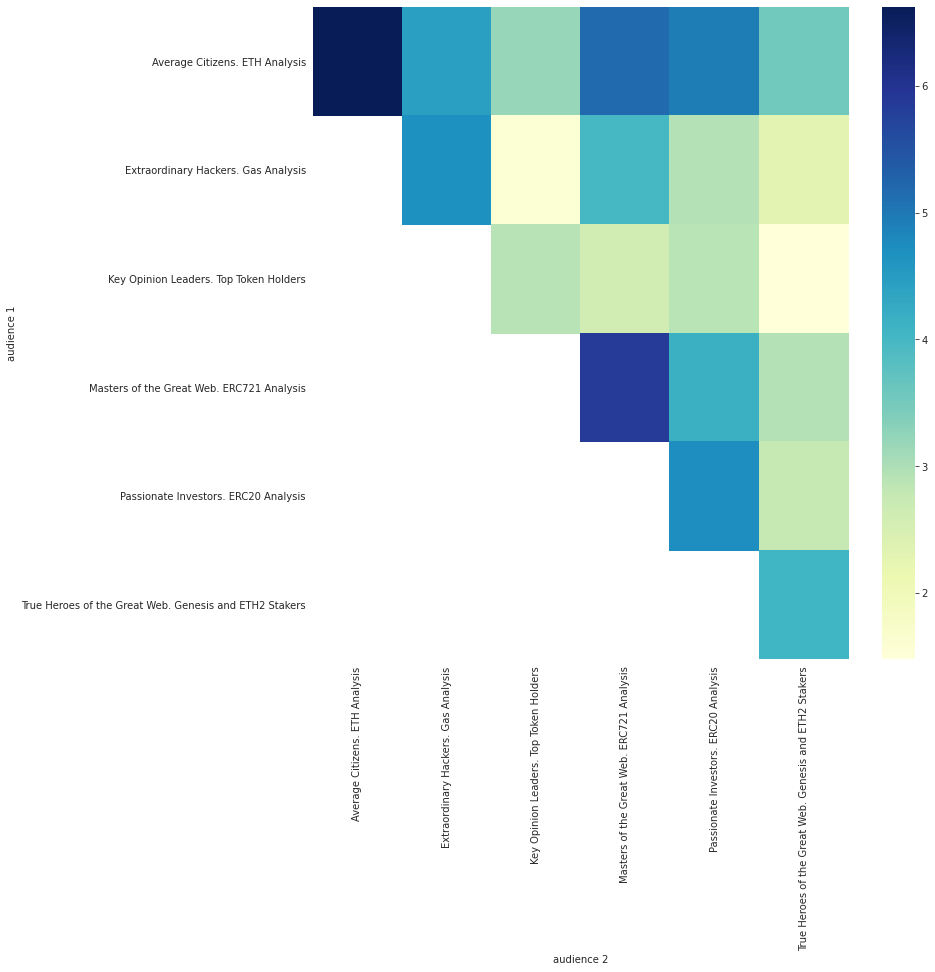

In [36]:

final_distribution_processed_df_data = []
for item_value in final_distribution_df.values:
    item_audiences_array = item_value[0]
    item_address_count = item_value[1]
    if len(item_audiences_array)> 1:
        final_distribution_processed_df_data.extend([[item_audiences[0], item_audiences[1], item_address_count] for item_audiences in itertools.combinations(np.sort(item_audiences_array), 2)])
    else:
        final_distribution_processed_df_data.append([item_audiences_array[0], item_audiences_array[0], item_address_count])
final_distribution_processed_df = pd.DataFrame(final_distribution_processed_df_data, columns=['audience 1', 'audience 2', 'number of addresses'])

f = lambda x: math.log(pd.Series.sum(x), 10)
sns.set_style("whitegrid")
plt.figure(figsize=(12, 12))
l2_pv_df = final_distribution_processed_df.pivot_table('number of addresses', 'audience 1', 'audience 2', aggfunc=f)
ax = sns.heatmap(l2_pv_df, cmap="YlGnBu")